# Example: parameter scan

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/ParameterScan.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/ParameterScan.ipynb), or just follow along with the output below.

<!-- <img src="img/splitter.png" alt="diagram" width="400"/>
 -->
In this notebook, we will show an example of using tidy3d to evaluate a device over a set of many design parameters.

For demonstration, we look at the splitting ratio of a directional coupler as we vary the coupling length between two waveguides.

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# gdspy is also needed for gds file manipulation
!pip install -q gdspy

# and tqdm will be used to print nice progressbars
!pip install -q tqdm

import tqdm
import gdspy

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print warning information to reduce verbosity
td.logging_level('warning')

## Setup

First we set up some global parameters

In [2]:
# wavelength / frequency
lambda0 = 1.550                     # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(n=wg_n)
mat_sub = td.Medium(n=sub_n)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# space between waveguide and PML
pml_spacing = 1
# Mesh step in all directions
mesh_step = 0.040     

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    # Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Create Simulation and Submit Job

The following function creates a tidy3d simulation object and submits it to our server, returning some handles to the simulation and job to be used to analyze results later.

In [20]:
def make_sim(coup_length, wg_spacing_coup):
    """ gets the parameters from the scan,
        creates a simulation,
        exports it to the server to run,
        returns a taskID handle to use to get the results later
    """
    
    gdspy.current_library = gdspy.GdsLibrary()
    lib = gdspy.GdsLibrary()

    # Geometry must be placed in GDS cells to import into Tidy3D
    coup_cell = lib.new_cell('Coupler')

    substrate = gdspy.Rectangle(
        (-device_length/2, -wg_spacing_in/2-10),
        (device_length/2, wg_spacing_in/2+10),
        layer=0)
    coup_cell.add(substrate)

    # Add the coupler to a gdspy cell
    gds_coup = make_coupler(
        device_length,
        wg_spacing_in,
        wg_width,
        wg_spacing_coup,
        coup_length,
        bend_length)
    coup_cell.add(gds_coup)

    # Substrate
    oxide = td.GdsSlab(
        material=mat_sub,
        gds_cell=coup_cell,
        gds_layer=0,
        z_min=-10,
        z_max=0)

    # Waveguides (import all datatypes if gds_dtype not specified)
    coupler = td.GdsSlab(
        material=mat_wg,
        gds_cell=coup_cell,
        gds_layer=1,
        z_cent=wg_height/2,
        z_size=wg_height,)

    # Simulation size along propagation direction
    sim_length = 2 + 2*bend_length + coup_length

    # Spacing between waveguides and PML
    sim_size = [
        sim_length,
        wg_spacing_in + wg_width + 2*pml_spacing,
        wg_height + 2*pml_spacing]


    # source
    src_pos = -sim_length/2 + 0.5
    msource = td.ModeSource(
        center=[src_pos , wg_spacing_in / 2 , wg_height / 2],
        size=[0, 3, 2],
        source_time = td.GaussianPulse(
            frequency=freq0,
            fwidth=fwidth),
        direction='forward')    

    domain_monitor = td.FreqMonitor(
        center = [0,0,wg_height/2],
        size = [sim_size[0], sim_size[1], 0],
        freqs = [freq0]
    )

    mon_in = td.ModeMonitor(
        center=[(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        Nmodes=1,
        name='in')
    mon_ref = td.ModeMonitor(
        center=[(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        Nmodes=1,
        name='refect')
    mon_top = td.ModeMonitor(
        center=[-(src_pos + 0.5), wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        Nmodes=1,
        name='top')
    mon_bot = td.ModeMonitor(
        center=[-(src_pos + 0.5), -wg_spacing_in / 2, wg_height / 2],
        size=[0, 3, 2],
        freqs=[freq0],
        Nmodes=1,
        name='bottom')
    wg_monitors = [mon_in, mon_ref, mon_top, mon_bot]

    # initialize the simulation
    sim = td.Simulation(
        size=sim_size,
        mesh_step=mesh_step, 
        structures=[oxide, coupler],
        sources=[msource],
        monitors=[domain_monitor] + wg_monitors,
        run_time=20/fwidth,
        pml_layers=[12, 12, 12])

    # set the modes
    sim.compute_modes(msource, Nmodes=2)
    sim.set_mode(msource, mode_ind=0)

    # export simulation to run, get taskID to refer to later
    project = web.new_project(sim.export(), task_name='CouplerVerify')
    taskId = project['taskId']

    return sim, taskId

## Test on a Single Simulation

Let's inspect a single simulation to make sure it was defined correctly before doing the full scan.

In [27]:
# Length of the coupling region
coup_length = 10

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

sim, taskId = make_sim(coup_length, wg_spacing_coup)

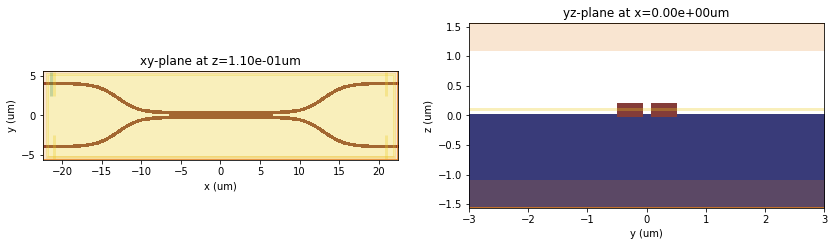

In [28]:
# visualize geometry
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sim.viz_mat_2D(normal='z', position=wg_height/2, ax=ax1);
sim.viz_mat_2D(normal='x', ax=ax2, source_alpha=1);
ax2.set_xlim([-3, 3])
plt.show()    

### Measure Fields and Transmission

The following function takes a completed job, loads the data and computes some results.

For this case, we measure both the total transmission in the right ports and also the ratio of power between the top and bottom ports.

In [24]:
def measure_transmission(sim, taskId, verbose=False):

    # download results if the job has finished
    web.download_results(taskId, target_folder='out/')
    if verbose:
        web.monitor_project(taskId)
        with open("out/tidy3d.log") as f:
             print(f.read())
    sim.load_results('out/monitor_data.hdf5')

    def get_power(monitor):
        f, b = sim.data(monitor)['mode_amps']
        F, B = np.abs(f)**2, np.abs(b)**2
        return F, B

    _, incident, reflect, top, bot = sim.monitors

    norm, _ = get_power(incident)
    norm = np.squeeze(norm)

    S = np.zeros((2, 2))
    S[0,0] = get_power(incident)[-1]
    S[1,0] = get_power(reflect)[-1]
    S[0,1] = get_power(top)[0]
    S[1,1] = get_power(bot)[0]
    S = S/norm

    split_ratio = S[0, 1] / (S[0, 1] + S[1, 1])
    efficiency = (S[0, 1] + S[1, 1]) / norm

    if verbose:
        print(f'split ratio of {(split_ratio * 100):.2f}% to top port')
        print(f'efficiency of {(efficiency * 100):.2f}% to transmission port')

    return split_ratio, efficiency

In [25]:
# monitor and test out the measure_transmission function the results of the single run
web.monitor_project(taskId)
split_ratio, efficiency = measure_transmission(sim, taskId, verbose=True)

Project "CouplerVerify-502-619" status: success...        

Project "CouplerVerify-502-619" status: success...    

Simulation domain Nx, Ny, Nz: 1124, 285, 79.
Total number of computational grid points: 2.53e+07.
Total number of time steps: 14915.
Time step: 6.932999e-17.
Starting Tidy3D... 

Setup time (s): 0.8003
- Time step    745 / time 5.17e-14fs (  5 % done), field decay: 1.00e+00
- Time step   1491 / time 1.03e-13fs ( 10 % done), field decay: 1.00e+00
- Time step   2237 / time 1.55e-13fs ( 15 % done), field decay: 1.00e+00
- Time step   2982 / time 2.07e-13fs ( 20 % done), field decay: 1.00e+00
- Time step   3728 / time 2.58e-13fs ( 25 % done), field decay: 9.74e-01
- Time step   4474 / time 3.10e-13fs ( 30 % done), field decay: 9.83e-01
- Time step   5220 / time 3.62e-13fs ( 35 % done), field decay: 9.78e-01
- Time step   5965 / time 4.14e-13fs ( 40 % done), field decay: 9.68e-01
- Time step   6711 / time 4.65e-13fs ( 45 % done), field decay: 9.69e-01
- Time step   7457 / time

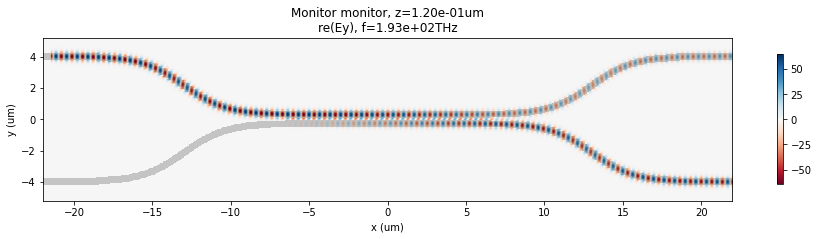

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
sim.viz_field_2D(sim.monitors[0], ax=ax, cbar=True, comp='y', val='re', eps_alpha=0.2)
plt.show()

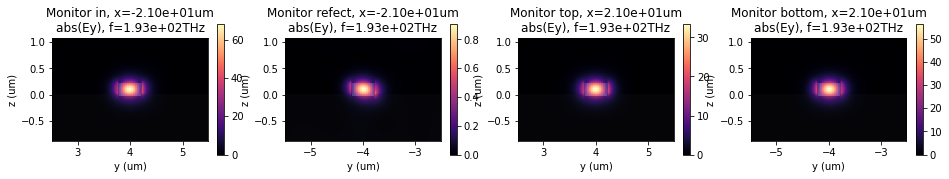

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for m, ax in zip(sim.monitors[1:], axes):
    im = sim.viz_field_2D(m, ax=ax, cbar=True, comp='y', val='abs', eps_alpha=0.2);

## 1D Parameter Scan

Now we will scan through the coupling length parameter to see the effect on splitting ratio.

We split the scan up into three steps:
1. Submit Job
2. Monitor Job
3. Post-process Result

For each step, we loop through all parameter combinations before continuing.

While it isn't necessary to do the scan this way, it cuts down on the total time because the instance can work on pre-processing the next job while the current job is running.

In [15]:
# create variables to store parameters, simulation information, results
Nl = 20

ls = np.linspace(5, 12, Nl)

sims = []
taskids = []

split_ratios = np.zeros(Nl)
efficiencies = np.zeros(Nl)


### Submit All Jobs

This for loop creates and exports all simulations to the server to run.

In [16]:
# submit all jobs
for i, l in enumerate(tqdm.tqdm(ls)):
    sim, taskId = make_sim(l, wg_spacing_coup)
    sims.append(sim)
    taskids.append(taskId)

100%|██████████| 20/20 [00:45<00:00,  2.25s/it]


### Monitor All Jobs

This for loop monitors each project one by one.

In [17]:
for i, taskId in enumerate(taskids):
    print(f'monitoring project ({i+1} / {Nl}):')
    web.monitor_project(taskId)

monitoring project (1 / 20):
Project "CouplerVerify-502-599" status: success...        

monitoring project (2 / 20):
Project "CouplerVerify-502-600" status: success...        

monitoring project (3 / 20):
Project "CouplerVerify-502-601" status: success...        

monitoring project (4 / 20):
Project "CouplerVerify-502-602" status: success...        

monitoring project (5 / 20):
Project "CouplerVerify-502-603" status: success...        

monitoring project (6 / 20):
Project "CouplerVerify-502-604" status: success...        

monitoring project (7 / 20):
Project "CouplerVerify-502-605" status: success...        

monitoring project (8 / 20):
Project "CouplerVerify-502-606" status: success...        

monitoring project (9 / 20):
Project "CouplerVerify-502-607" status: success...        

monitoring project (10 / 20):
Project "CouplerVerify-502-608" status: success...        

monitoring project (11 / 20):
Project "CouplerVerify-502-609" status: success...        

monitoring project 

### Download and Compute Results

This loop download and loads the completed simulations, computes the efficiency and split ratio, and records them in an array

In [18]:
# get results from all jobs
for i in tqdm.tqdm(range(Nl)):
    sim = sims[i]
    taskId = taskids[i]
    split_ratio, efficiency = measure_transmission(sim, taskId)
    split_ratios[i] = split_ratio
    efficiencies[i] = efficiency

100%|██████████| 20/20 [02:33<00:00,  7.67s/it]


### Plot

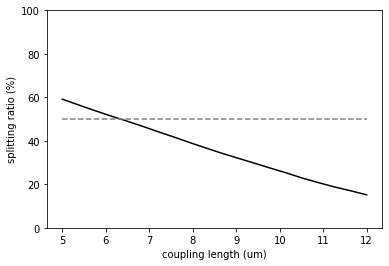

In [19]:
plt.plot(ls, 100*split_ratios, 'k')
plt.plot(ls, 50 * np.ones_like(ls), 'gray', linestyle='--')
plt.xlabel('coupling length (um)')
plt.ylabel('splitting ratio (%)')
plt.ylim(0, 100)
plt.show()

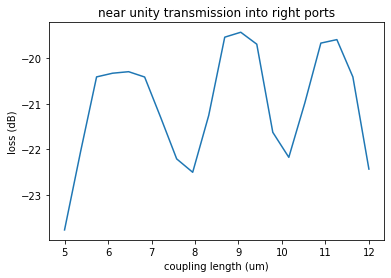

In [26]:
loss_db = 10 * np.log10(1 - efficiencies)
plt.plot(ls, loss_db)

plt.xlabel('coupling length (um)')
plt.ylabel('loss (dB)')
plt.title('near unity transmission into right ports')
# plt.yscale('symlog')
# plt.ylim(-1e-1, 0)
plt.show()